<a href="https://colab.research.google.com/github/nioclandramer/IA_ComSexista/blob/main/IA_comentSexistas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLASIFICACIÓN DEL SEXISMO EN TEXTOS EN INGLÉS**


---




Inteligencia Artificial G3 2024-2

Grupo de trabajo No. 3
* Kevin Arias
* Gabriela Cera
* Andrés Echeverri
* Leonard Ferreira





# 🟣 **Descripción del problema**

El siguiente trabajo se realiza a base del conjunto de datos tomado de: https://www.kaggle.com/datasets/aadyasingh55/sexism-detection-in-english-texts?resource=download

Este conjunto de datos incluye 2000 entradas de texto en inglés y 4 columnas:
* ***Text:*** Contiene al comentario.
* ***Label_sexist:*** Clasifica al comentario en sexista y no sexista.
* ***Label_category:*** Clasifica los comentarios, "***none***" si no es sexista, y si lo es, hay 4 tipos:
 1. ***Threats, plans to harm and incitement* (Amenazas)**: Expresar la intención de causar daño físico o psicológico a alguien por su género. Ej: "Te voy a pegar".
 2. ***Derogation* (Derogación)**: Despreciar o humillar a una persona por su género. Ej: "Las mujeres no saben conducir".
 3. ***Animosity* (Animosidad)**: Sentir odio o resentimiento hacia las mujeres. Ej: "Odio a las feministas".
 4. ***Prejudiced discussions* (Discusiones prejuiciosas)**: Difundir creencias falsas sobre las mujeres y justificar la desigualdad de género. Ej: "Los hombres son los jefes de la casa".

* ***Label_vector:*** Es una subcategoría, contiene: "***none***" y:
 2. 1 descriptive attacks
 2. 2 aggressive and emotive attacks
 3. 1 casual use of gendered slurs, profanities, and insults
 3. 2 immutable gender differences and gender stereotypes


**Objetivos específicos:**

Este trabajo solo se enfoca en los comentarios sexistas y en sus 4 categorías, con estos datos los objetivos son:

* **Realizar Análisis Exploratorio de Datos (EDA):** Analizar la distribución y características de los comentarios sexistas.

* **Filtrar y Preprocesar Datos Sexistas:** Extraer y normalizar los comentarios sexistas y sus categorías en un formato comprensible para la máquina.

* **Dividir el Dataset:** Separar los datos sexistas en conjuntos de entrenamiento y prueba.

* **Seleccionar y Entrenar Modelos:** Investigar y entrenar el modelos de machine learning para la clasificación de comentarios sexistas.

* **Evaluar el Modelo:** Medir el rendimiento del modelo e identificar los errores.


**Descripción de variables:**

El nuevo dataset tendrá unicamente las variables:
* ***Text* (variable predictora X):** los comentarios sexistas
* ***Label_category* (variable objetivo Y):** con sus 4 categorías

**Librerias utilizadas:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

#Para graficos
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#Para Preprocesamiento de datos
import re
  #Para corrección ortográfica
!pip install pyspellchecker
from spellchecker import SpellChecker

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Para vectorizacion de datos
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Para seleccion de características
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier

# 🟢 **Obtener y entender los datos**

**Carga y extracción del dataset:**

In [ ]:
# Ruta del archivo CSV en Google Drive
dataset = "/content/drive/MyDrive/Colab Notebooks/dev.csv"


# Leer el archivo CSV en un DataFrame
datosOriginales = pd.read_csv(dataset, encoding='utf-8', nrows=100000)

# Verificar que los datos se hayan cargado correctamente
print(datosOriginales.head())

                  rewire_id  \
0   sexism2022_english-9609   
1    sexism2022_english-966   
2   sexism2022_english-3553   
3  sexism2022_english-13328   
4     sexism2022_english-81   

                                                text label_sexist  \
0  In Nigeria, if you rape a woman, the men rape ...   not sexist   
1                     I bet she wished she had a gun   not sexist   
2  I agree with that but at the same time I know ...       sexist   
3  democrats from Minnesota (leftist muzzie shith...       sexist   
4  Texas jury sentences Jordanian immigrant to de...   not sexist   

  label_category                        label_vector split  
0           none                                none   dev  
1           none                                none   dev  
2  2. derogation             2.1 descriptive attacks   dev  
3  2. derogation  2.2 aggressive and emotive attacks   dev  
4           none                                none   dev  


In [ ]:
#Extración de los comentarios sexistas más sus categorías (dos columnas):

# Filtrar las filas según el label (categoria)
filtrado = datosOriginales[datosOriginales['label_sexist'] == 'sexist']

# Seleccionar columnas específicas que conformarán los nuevos datos
# y hacer una copia
datos = filtrado[['text', 'label_category']].copy()

# Contar la cantidad de comentarios por tipo
conteo_tipos = datos['label_category'].value_counts()

# Mostrando el cambio
print(datos.head(10))

                                                 text  \
2   I agree with that but at the same time I know ...   
3   democrats from Minnesota (leftist muzzie shith...   
7            aim for the head so she dosn't come back   
9   This guys gonna have a great time in the barra...   
13              Or women can stop being lying whores.   
15  until she's been around me long enough through...   
19  What a nasty bitch. I would’ve failed her on t...   
27  Habits are hard to die, as much as the cock ca...   
36  I am with you on the False Accuser Registry. s...   
39  She’s unstable, you’ll never know when she mig...   

                              label_category  
2                              2. derogation  
3                              2. derogation  
7   1. threats, plans to harm and incitement  
9                               3. animosity  
13                             2. derogation  
15                 4. prejudiced discussions  
19                 4. prejudiced discussion

**Análisis Exploratorio de Datos (EDA):**

<ipython-input-5-592d5ea8e497>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_tipos.index, y=conteo_tipos.values, palette=colors)


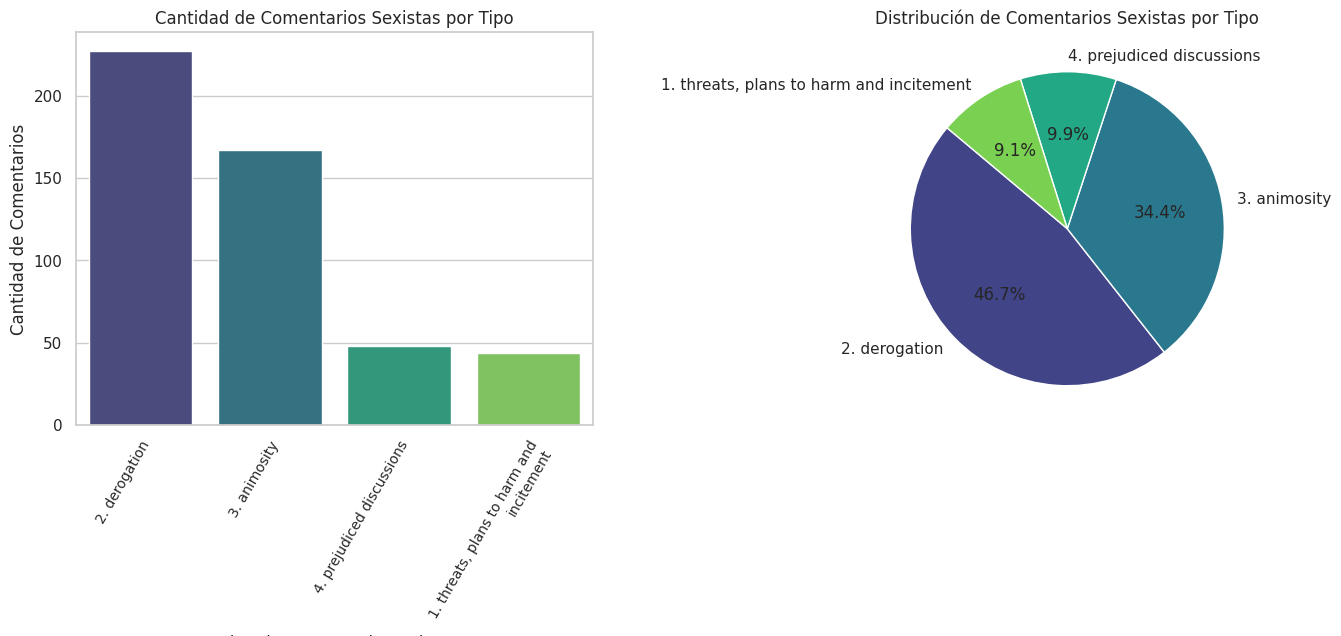

In [ ]:
# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Ajustar el tamaño de la figura según el número de categorías
fig_width = max(14, len(conteo_tipos) * 1.5)
plt.figure(figsize=(fig_width, 6))

# configuración para el gráfico de barras
plt.subplot(1, 2, 1)
colors = sns.color_palette("viridis", len(conteo_tipos))
sns.barplot(x=conteo_tipos.index, y=conteo_tipos.values, palette=colors)
plt.xlabel('Tipo de Comentario Sexista')
plt.ylabel('Cantidad de Comentarios')
plt.title('Cantidad de Comentarios Sexistas por Tipo')

# Rotar y ajustar el tamaño de las etiquetas en el eje x
plt.xticks(rotation=60, ha='right', fontsize=10, wrap=True)

# configuración para el gráfico de pastel
plt.subplot(1, 2, 2)
plt.pie(conteo_tipos.values, labels=conteo_tipos.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribución de Comentarios Sexistas por Tipo')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()

🤔 Se observa que los datos están desbalanceados, más adelante se sabrá si esto afecta realmente a los resultados y si se deben tomar medidas al repecto

# 🔵 **Limpieza de los datos y feature engineering**


## 🔹 **Preprocesamiento de datos**

Para poder usar nuestro dataset como datos de entrenamiento, primero se debe procesar el texto que contiene siguiendo los siguientes pasos:

* **Limpieza de Datos:** Eliminar duplicados, vacíos, *(puede hacerse) corregir errores tipográficos y eliminar comentarios irrelevantes*.
* **Normalización:** Convertir todo el texto a minúsculas, eliminar puntuación, caracteres especiales y números, corregir contracciones mediante un diccionario, reemplazar mutiples espacios en blanco por uno solo.
* **Tokenización:** Dividir el texto en palabras o tokens individuales.
* **Eliminación de Stop Words:** Quitar palabra que no aportan mucho significado (como "y", "el", "de").
* **Lematización:** Reducir las palabras a su raíz.



### Limpieza de datos:

**Revisión de valores nulos:**

In [ ]:
# Contar valores nulos en cada columna
nulos = datos.isnull().sum()
print(nulos)

# Obtener un resumen del dataframe
datos.info()

text              0
label_category    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 486 entries, 2 to 1985
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            486 non-null    object
 1   label_category  486 non-null    object
dtypes: object(2)
memory usage: 11.4+ KB


No se encuentran valores nulos en los datos

**Revisión de filas duplicadas:**

In [ ]:
num_duplicados = datos.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicados}")

# Mostrar las filas duplicadas
if num_duplicados > 0:
    duplicados = datos[datos.duplicated(keep=False)]  # keep=False muestra todos los duplicados
    print("Filas duplicadas:")
    print(duplicados)

Número de filas duplicadas: 0


### Normalización:

In [ ]:
contractions_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot", "cant": "cannot", #por si esta mal escrita
    "couldn't": "could not",
    "could've": "could have",
    "didn't": "did not",
    "doesn't": "does not", "dosn't": "does not",
    "don't": "do not",
    "dont": "do not",
    "gimme": "give me",
    "gonna": "going to",
    "gotta": "got to",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "im": "i am",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "mightn't": "might not",
    "might've": "might have",
    "mustn't": "must not",
    "must've": "must have",
    "needn't": "need not",
    "o'clock": "of the clock",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "shouldn't": "should not",
    "should've": "should have",
    "that's": "that is",
    "there'd": "there would",
    "there'll": "there will",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wanna": "want to",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'd": "what did",
    "what'll": "what will",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'd": "who would",
    "who'll": "who will",
    "who's": "who is",
    "who've": "who have",
    "why'd": "why did",
    "why'll": "why will",
    "why's": "why is",
    "won't": "will not",
    "wouldn't": "would not", "woudn't": "would not",
    "would've": "would have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all've": "you all have",
    "y'know": "you know",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

In [ ]:
# Inicializar el corrector ortográfico
spell = SpellChecker()

def normalizar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Reemplazar el apóstrofo tipográfico por el apóstrofo simple
    #para que las contracciones se reemplacen bien
    texto = texto.replace("’", "'")

    # Corregir errores ortográficos
    palabras = texto.split()
    palabras_corregidas = [spell.candidates(p).pop() if p in spell else p for p in palabras]
    texto = ' '.join(palabras_corregidas)

    #Eliminar contracciones
    for contraccion, expansion in contractions_dict.items():
        texto = re.sub(r'\b' + re.escape(contraccion) + r'\b', expansion, texto)
    # Eliminar puntuación, caracteres especiales y números
    texto = re.sub(r'[^a-z\s]', '', texto)
    # Reemplazar múltiples espacios en blanco por uno solo
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

# Verificar los resultados
print("Antes de la normalización:")
print(datos[['text']].head(10))  # Muestra las primeras 10 filas

# Aplicar la normalización a la columna 'text'
datos['cleaned_text'] = datos['text'].apply(normalizar_texto)

print("\nDespués de la normalización:")
print(datos[['cleaned_text']].head(10))  # Muestra las primeras 10 filas

Antes de la normalización:
                                                 text
2   I agree with that but at the same time I know ...
3   democrats from Minnesota (leftist muzzie shith...
7            aim for the head so she dosn't come back
9   This guys gonna have a great time in the barra...
13              Or women can stop being lying whores.
15  until she's been around me long enough through...
19  What a nasty bitch. I would’ve failed her on t...
27  Habits are hard to die, as much as the cock ca...
36  I am with you on the False Accuser Registry. s...
39  She’s unstable, you’ll never know when she mig...

Después de la normalización:
                                         cleaned_text
2   i agree with that but at the same time i know ...
3   democrats from minnesota leftist muzzie shitho...
7          aim for the head so she does not come back
9   this guys going to have a great time in the ba...
13               or women can stop being lying whores
15  until she is been aro

### Tokenización:

In [ ]:
# Descargar el paquete de tokenización
nltk.download('punkt')
nltk.download('punkt_tab')

# Tokenizar el texto
datos['cleaned_text'] = datos['cleaned_text'].apply(word_tokenize)

# Verificar los resultados
print(datos[['text', 'cleaned_text']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                                 text  \
2   I agree with that but at the same time I know ...   
3   democrats from Minnesota (leftist muzzie shith...   
7            aim for the head so she dosn't come back   
9   This guys gonna have a great time in the barra...   
13              Or women can stop being lying whores.   

                                         cleaned_text  
2   [i, agree, with, that, but, at, the, same, tim...  
3   [democrats, from, minnesota, leftist, muzzie, ...  
7   [aim, for, the, head, so, she, does, not, come...  
9   [this, guys, going, to, have, a, great, time, ...  
13       [or, women, can, stop, being, lying, whores]  


### Eliminación de Stop Words:

In [ ]:
# Descargar el conjunto de stop words
nltk.download('stopwords')

# Definir stop words en inglés
stop_words = set(stopwords.words('english'))

# Función para eliminar stop words
def eliminar_stop_words(tokens):
    return [word for word in tokens if word not in stop_words]

# Aplicar eliminación de stop words
datos['cleaned_text'] = datos['cleaned_text'].apply(eliminar_stop_words)

# Verificar los resultados
print(datos[['text', 'cleaned_text']].head())

                                                 text  \
2   I agree with that but at the same time I know ...   
3   democrats from Minnesota (leftist muzzie shith...   
7            aim for the head so she dosn't come back   
9   This guys gonna have a great time in the barra...   
13              Or women can stop being lying whores.   

                                         cleaned_text  
2   [agree, time, know, well, enough, say, love, w...  
3   [democrats, minnesota, leftist, muzzie, shitho...  
7                             [aim, head, come, back]  
9   [guys, going, great, time, barracks, know, fir...  
13                       [women, stop, lying, whores]  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Lematización:

In [ ]:
# Descargar los recursos necesarios
nltk.download('wordnet')
nltk.download('omw-1.4')

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

# Función para lematizar tokens
def lematizar_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Aplicar lematización
datos['cleaned_text'] = datos['cleaned_text'].apply(lematizar_tokens)

# Verificar los resultados de la lematización (como lista de palabras)
print(datos[['text', 'cleaned_text']].head())

# Ahora unir las palabras en una cadena para el resultado final
datos['cleaned_text'] = datos['cleaned_text'].apply(lambda x: ' '.join(x))

# Verificar los resultados finales
print("\nDespués de unir las palabras en una cadena:")
print(datos[['cleaned_text']].head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Error downloading 'omw-1.4' from
[nltk_data]     <https://raw.githubusercontent.com/nltk/nltk_data/gh-
[nltk_data]     pages/packages/corpora/omw-1.4.zip>:   [SSL:
[nltk_data]     DECRYPTION_FAILED_OR_BAD_RECORD_MAC] decryption failed
[nltk_data]     or bad record mac (_ssl.c:2578)


                                                 text  \
2   I agree with that but at the same time I know ...   
3   democrats from Minnesota (leftist muzzie shith...   
7            aim for the head so she dosn't come back   
9   This guys gonna have a great time in the barra...   
13              Or women can stop being lying whores.   

                                         cleaned_text  
2   [agree, time, know, well, enough, say, love, w...  
3   [democrat, minnesota, leftist, muzzie, shithol...  
7                             [aim, head, come, back]  
9   [guy, going, great, time, barrack, know, first...  
13                        [woman, stop, lying, whore]  

Después de unir las palabras en una cadena:
                                         cleaned_text
2   agree time know well enough say love woman min...
3   democrat minnesota leftist muzzie shithole dum...
7                                  aim head come back
9   guy going great time barrack know first time t...
13    

### Análisis Exploratorio de Datos (EDA):

Aquí se puede visualizar la frecuencia en la que aparecen las palabras por cada categoría

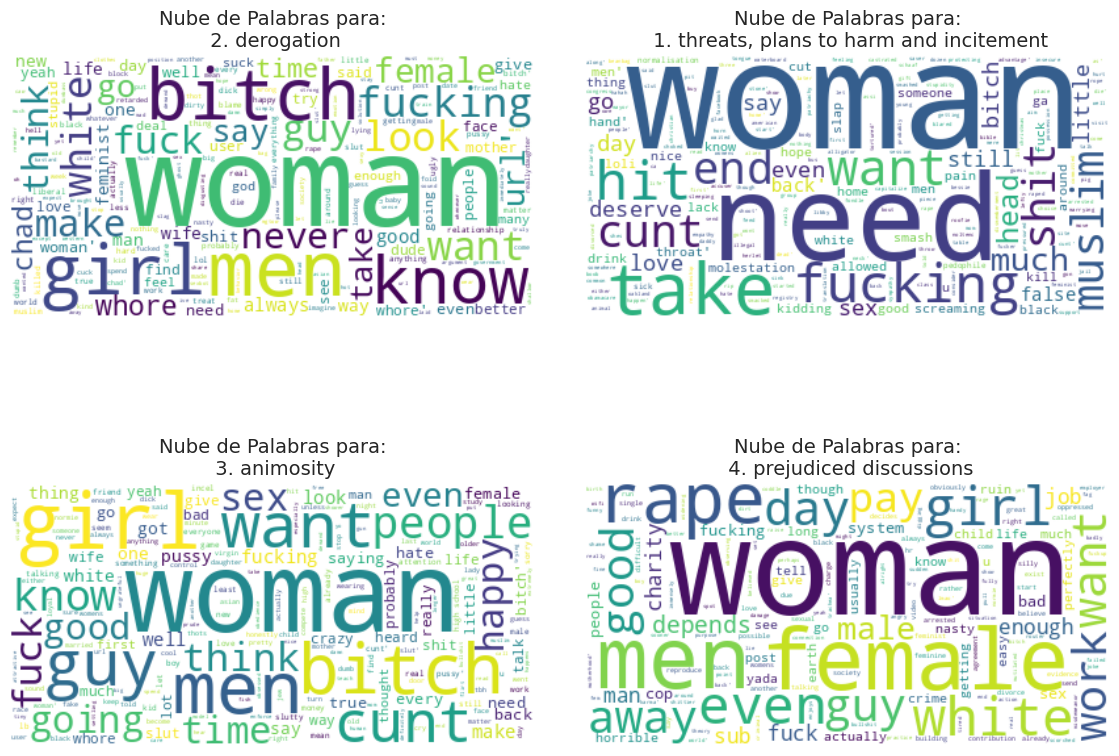

In [ ]:
# Generar nubes de palabras para cada categoría
categories = datos['label_category'].unique()

# Crear una figura con subgráficas (2x2)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar el acceso

for i, category in enumerate(categories):
    # Filtrar comentarios por categoría
    text = datos[datos['label_category'] == category]['cleaned_text'].values

    # Crear una nube de palabras
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(str(text))

    # Mostrar la nube de palabras en el subplot correspondiente
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')  # Ocultar ejes
    axes[i].set_title(f'Nube de Palabras para:\n {category}', fontsize=14)

# Ajustar el espacio entre subgráficas
plt.tight_layout(pad=3.0)
plt.show()

## 🔹 **Vectorización de los datos**


Convierte los comentarios de texto en una representación numérica que puede ser utilizada por algoritmos de aprendizaje automático.

* **Bag of Words** - BoW (Bolsa de Palabras): convierte el texto en una matriz de conteos de palabras, la matriz de contingencia que relaciona las palabras con las categorías.
* **TF-IDF** (Frecuencia de Término - Frecuencia Inversa de Documento): no solo cuenta las ocurrencias de palabras, sino que también considera su importancia en el conjunto de datos. Reduce el peso de las palabras comunes y aumenta el peso de las palabras raras.


//explicar por que elegimos usar TF-IDF en vez de BoW  

### BoW:

In [ ]:
# Crear una instancia de CountVectorizer
vectorizador2= CountVectorizer(min_df=0.005)

# Ajustar y transformar los datos
X = vectorizador2.fit_transform(datos['cleaned_text'])

# Convertir a un DataFrame para visualizar
df_count = pd.DataFrame(X.toarray(), columns=vectorizador2.get_feature_names_out())

#MATRIZ DE CONTINGENCIA
# Añadir la columna de categorías
df_count['label_category'] = datos['label_category']

# Crear la tabla de contingencia
contingency_table = df_count.groupby('label_category').sum()

# Resetear el índice para que sea más fácil de leer
contingency_table.reset_index(inplace=True)

# Mostrar la tabla de contingencia
print(contingency_table)

                             label_category  able  abusive  act  actual  \
0  1. threats, plans to harm and incitement     0        0    0       0   
1                             2. derogation     0        1    1       0   
2                              3. animosity     1        1    0       0   
3                 4. prejudiced discussions     0        0    0       1   

   actually  age  agree  allowed  alone  ...  worse  would  wrong  wrote  \
0         0    0      0        0      1  ...      0      2      0      0   
1         2    1      0        0      0  ...      0      6      0      1   
2         0    0      0        0      0  ...      0      5      3      0   
3         2    0      0        0      1  ...      0      3      1      0   

   yeah  year  yep  yet  yo  young  
0     0     1    0    0   0      0  
1     0     0    0    0   0      0  
2     1     0    1    1   0      0  
3     0     0    0    0   1      0  

[4 rows x 455 columns]


### TF-IDF:

In [ ]:
# Crear una instancia de TfidfVectorizer
vectorizador = TfidfVectorizer(min_df=0.005)

# Ajustar y transformar los datos
X_tfidf = vectorizador.fit_transform(datos['cleaned_text'])
y = datos['label_category']

# Convertir a un DataFrame para visualizar
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns = vectorizador.get_feature_names_out())
# Agregar la columna de categorías
#df_tfidf['label_category'] = y.reset_index(drop=True)
#print(df_tfidf.head())
df_tfidf['label_category'] = datos['label_category']

#MATRIZ DE CONTINGENCIA
# Añadir la columna de categorías

# Crear la tabla de contingencia
contingency_table = df_tfidf.groupby('label_category').sum()

# Resetear el índice para que sea más fácil de leer
contingency_table.reset_index(inplace=True)

# Mostrar la tabla de contingencia
print(contingency_table)

                             label_category      able   abusive       act  \
0  1. threats, plans to harm and incitement  0.000000  0.000000  0.000000   
1                             2. derogation  0.000000  0.726198  0.392436   
2                              3. animosity  0.325904  0.536819  0.000000   
3                 4. prejudiced discussions  0.000000  0.000000  0.000000   

     actual  actually      age  agree  allowed     alone  ...  worse  \
0  0.000000  0.000000  0.00000    0.0      0.0  0.296275  ...    0.0   
1  0.000000  0.649889  0.34115    0.0      0.0  0.000000  ...    0.0   
2  0.000000  0.000000  0.00000    0.0      0.0  0.000000  ...    0.0   
3  0.347047  0.620383  0.00000    0.0      0.0  0.380533  ...    0.0   

      would     wrong     wrote      yeah      year       yep       yet  \
0  0.432512  0.000000  0.000000  0.000000  0.209874  0.000000  0.000000   
1  1.236993  0.000000  0.409715  0.000000  0.000000  0.000000  0.000000   
2  1.076138  0.828617  0.000

## 🔹 **Selección de características**

Se comenzará con un métodos de filtro (**Chi2**) para una preselección rápida, para luego refinar esa selección con (**Random Forest**)

*   **//** Para mostrar las palabras diferenciadoras por cada categoría.
*   *Elemento de lista*



## Filtro basado en el estadístico Chi_square:

Usando la impementación de TF-IDF anterior

In [ ]:
chi2_selector = SelectKBest(chi2, k=100)  # Cambia k según tus necesidades
X_chi2 = chi2_selector.fit_transform(X_tfidf, y)

# Obtener las características seleccionadas
selected_features_chi2 = chi2_selector.get_support(indices=True)
feature_names_chi2 = vectorizador.get_feature_names_out()

# Imprimir cuántas palabras han sido seleccionadas y mostrar las primeras 10
print(f"Numero de palabras seleccionadas por Chi-Cuadrado: {len(selected_features_chi2)}")
selected_words_chi2 = feature_names_chi2[selected_features_chi2]
print("Primeras 10 palabras seleccionadas:")
print(selected_words_chi2[:10])


Numero de palabras seleccionadas por Chi-Cuadrado: 100
Primeras 10 palabras seleccionadas:
['allowed' 'already' 'arrested' 'as' 'attracted' 'away' 'back' 'bad'
 'believe' 'building']


## Random Forest para refinar:

Numero de palabras seleccionadas por Random Forest: 31
Primeras 10 palabras seleccionadas:
['woman' 'cunt' 'need' 'female' 'fucking' 'pussy' 'happy' 'take' 'whore'
 'going']


<ipython-input-19-c36576a2b3e6>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_words['importance'], y=top_words['feature'], palette='viridis')


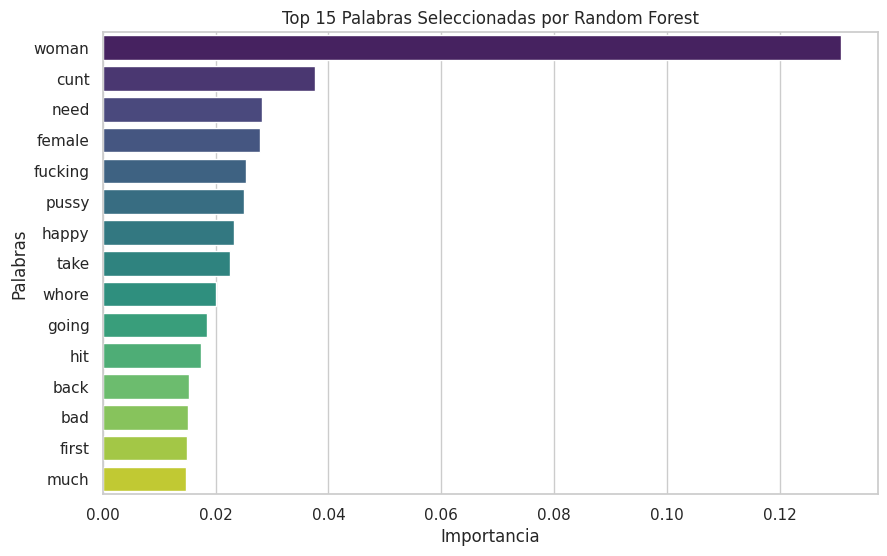

In [ ]:
# usando solo las caracteristicas seleccionadas por Chi-Cuadrado
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_chi2, y)

# Obtener la importancia de las características
importances = rf.feature_importances_

# Crear un DataFrame para manejar las importancias y las palabras
importance_df = pd.DataFrame({
    'feature': selected_words_chi2,
    'importance': importances
})

# Ordenar el DataFrame por importancia
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Seleccionar las características más importantes
umbral = 0.01
selected_features_rf = importance_df[importance_df['importance'] > umbral]


# Imprimir cuántas palabras han sido seleccionadas y las primeras 10
print(f"Numero de palabras seleccionadas por Random Forest: {len(selected_features_rf)}")
print("Primeras 10 palabras seleccionadas:")
print(selected_features_rf['feature'].head(10).values)

# Graficar el top 15
top_words = selected_features_rf.head(15)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_words['importance'], y=top_words['feature'], palette='viridis')
plt.title('Top 15 Palabras Seleccionadas por Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Palabras')
plt.show()

In [ ]:
# from sklearn.feature_selection import chi2
# import numpy as np

# # Calcular Chi-Cuadrado
# chi2_values, p_values = chi2(X_tfidf, y)

# # Crear un DataFrame con palabras y puntajes de Chi-cuadrado
# chi2_df = pd.DataFrame({
#     'Palabras': vectorizador2.get_feature_names_out(),
#     'valor_chi2': chi2_values
# })

# # Identificar palabras diferenciadoras por categoría
# top_words_by_category = {}
# for category in np.unique(y):
#     # Filtrar datos para la categoría actual
#     category_indices = (y == category)
#     chi2_values_category, _ = chi2(X_tfidf[category_indices], y[category_indices])

#     # Crear un DataFrame de Chi-cuadrado para esta categoría
#     category_df = pd.DataFrame({
#         'Palabras': vectorizador2.get_feature_names_out(),
#         'valor_chi2': chi2_values_category
#     }).sort_values(by='valor_chi2', ascending=False)

#     # Guardar el Top 15 palabras para la categoría
#     top_words_by_category[category] = category_df.head(15)


# # Mostrar el Top 15 palabras diferenciadoras por categoría
# print("\nTop 15 palabras diferenciadoras por categoría (ordenadas por Chi2):")
# for category, top_words in top_words_by_category.items():
#     print(f"\nCategoría: {category}")
#     print(top_words)


Top 15 palabras diferenciadoras por categoría (ordenadas por Chi2):

Categoría: 1. threats, plans to harm and incitement
    Palabras  valor_chi2
0       able         NaN
1      about         NaN
2    abusive         NaN
3        act         NaN
4     actual         NaN
5   actually         NaN
6      after         NaN
7      again         NaN
8        age         NaN
9      agree         NaN
10       all         NaN
11   allowed         NaN
12     alone         NaN
13     alpha         NaN
14   already         NaN

Categoría: 2. derogation
    Palabras  valor_chi2
0       able         NaN
1      about         NaN
2    abusive         NaN
3        act         NaN
4     actual         NaN
5   actually         NaN
6      after         NaN
7      again         NaN
8        age         NaN
9      agree         NaN
10       all         NaN
11   allowed         NaN
12     alone         NaN
13     alpha         NaN
14   already         NaN

Categoría: 3. animosity
    Palabras  valor_chi2
0 

***Lasso***, *para saber que variables no son importantes en el modelo (**selección de características**), y que se pueden quitar*

## 🔹 **(*Podría hacerse*) Análisis de Sentimiento o Clasificación**

***Diccionario de Sentimiento:*** *Usar un diccionario que contenga palabras o frases que se consideran sexistas o discriminatorias. Esto puede ser útil en la fase de análisis para identificar patrones en los comentarios.*

# 🟠 **Seleccionar el modelo, ajustarlo y evaluarlo**

**Dividir el Dataset:** El dataset ya está separado en Kaggle, en un archivo train para entrenamiento y test para prueba

**Requisito:**

 Descripción de los experimentos realizados para ajustar los parámetros cada uno de los métodos vistos en clase. Al ajustar los parámetros tenga en cuenta que debe
tratar de alcanzar el mejor desempeño posible sobre el conjunto de entrenamiento, y al final evaluar cada modelo sobre un conjunto de prueba. Los métodos para evaluar
son: regresión multivariada, árboles de decisión, random forest, y redes neuronales. Puede utilizar la función GridSearchCV la cual además de automatizar las pruebas
de múltiples combinaciones de parámetros, también implementa una estrategia de repetición de cada experimento llamada validación cruzada.

**Nota:** la implementación de redes neuronales profundas es opcional, los grupos que lleguen a implementar redes neuronales profunda recibirán adicional a la nota de esta actividad
hasta 20 puntos, para tal caso el modelo de red neuronal profundo diseñado y evaluado deberá ser sustentado al igual que el resto de los métodos.

Se hace la implementación de todos estos modelos:

1. Regresión multivariada
2. Árboles de decisión
3. Random Forest
4. Redes neuronales
5. Redes neuronales profundas 20 pntos extra

Comparando sus resultados (**Accuracy y Matriz de confusión**) probando diferentes parámetros (*decirlos*) utilizando la función GridSearchCV la cual además de automatizar las pruebas de múltiples combinaciones de parámetros, también implementa una estrategia de repetición de cada experimento llamada validación cruzada.




## 🔸 **Regresión multivariada:**

**PARAMETROS:** El parámetro que vas a usar y su respectivos resultados de la evaluación:


In [ ]:
#desarrollar aquí con esos parámetros

# imprime esto:
# EVALUACIÓN:
# Accuracy: //resultado aquí

# Matriz de confusión: //imprime debajo

**PARAMETROS:** El parámetro que vas a usar y su respectivos resultados de la evaluación:


In [ ]:
#desarrollar aquí con esos parámetros

# imprime esto:
# EVALUACIÓN:
# Accuracy: //resultado aquí

# Matriz de confusión: //imprime debajo

**Requisito:** Una explicación o análisis del resultado final obtenido por los modelos con los parámetros ajustados debe incluir métricas de evaluación como accuracy, y matrices de
confusión. Este análisis también debe aparecer descrito y documentado en el notebook de trabajo.

//añadir las fuentes

## 🔸 **Árboles de decisión:**



**PARAMETROS:** El parámetro que vas a usar y su respectivos resultados de la evaluación:


In [ ]:
#desarrollar aquí con esos parámetros

# imprime esto:
# EVALUACIÓN:
# Accuracy: //resultado aquí

# Matriz de confusión: //imprime debajo

**PARAMETROS:** El parámetro que vas a usar y su respectivos resultados de la evaluación:


In [ ]:
#desarrollar aquí con esos parámetros

# imprime esto:
# EVALUACIÓN:
# Accuracy: //resultado aquí

# Matriz de confusión: //imprime debajo

**Requisito:** Una explicación o análisis del resultado final obtenido por los modelos con los parámetros ajustados debe incluir métricas de evaluación como accuracy, y matrices de
confusión. Este análisis también debe aparecer descrito y documentado en el notebook de trabajo.

//añadir las fuentes

## 🔸 **Random Forest:**





**PARAMETROS:** El parámetro que vas a usar y su respectivos resultados de la evaluación:


In [ ]:
#desarrollar aquí con esos parámetros
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import cross_val_score

# Paso 1: Convertir las etiquetas categóricas a valores numéricos usando LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Etiquetas convertidas a números

# Paso 2: Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.3, random_state=42)

# Paso 3: Crear y entrenar el modelo de RandomForestRegressor
clf = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=42)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=2)
clf.fit(X_train, y_train)



# Evaluar el rendimiento del modelo en los datos de entrenamiento y prueba

train_accuracy = clf.score(X_train, y_train) * 100
test_accuracy = clf.score(X_test, y_test) * 100

# Mostrar el rendimiento del modelo para entrenamiento y prueba
print("Desempeño del modelo para el conjunto de entrenamiento")
print("--------------------------------------")
print("Precisión del entrenamiento:", "{:.3f}%".format(train_accuracy))
print("Precisión de prueba:", "{:.3f}%".format(test_accuracy))



# imprime esto:
# EVALUACIÓN:
# Accuracy: //resultado aquí

# Matriz de confusión: //imprime debajo


Desempeño del modelo para el conjunto de entrenamiento
--------------------------------------
Precisión del entrenamiento: 82.647%
Precisión de prueba: 47.945%


**PARAMETROS:** El parámetro que vas a usar y su respectivos resultados de la evaluación:


In [ ]:
#desarrollar aquí con esos parámetros


# imprime esto:
# EVALUACIÓN:
# Accuracy: //resultado aquí

# Matriz de confusión: //imprime debajo

**Requisito:** Una explicación o análisis del resultado final obtenido por los modelos con los parámetros ajustados debe incluir métricas de evaluación como accuracy, y matrices de
confusión. Este análisis también debe aparecer descrito y documentado en el notebook de trabajo.

//añadir las fuentes

## 🔸 **Redes neuronales:**



**PARAMETROS:** El parámetro que vas a usar y su respectivos resultados de la evaluación:


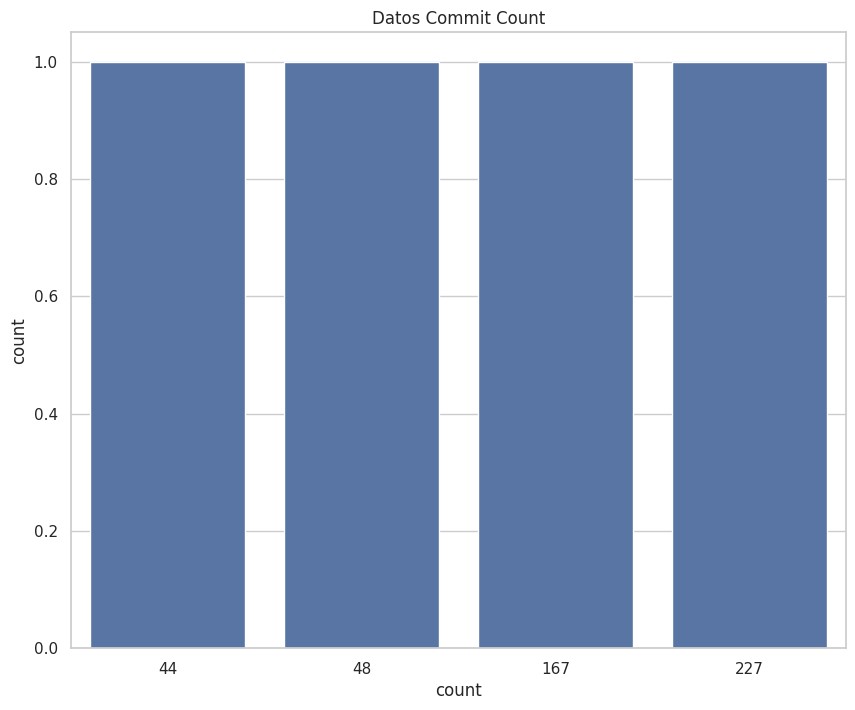

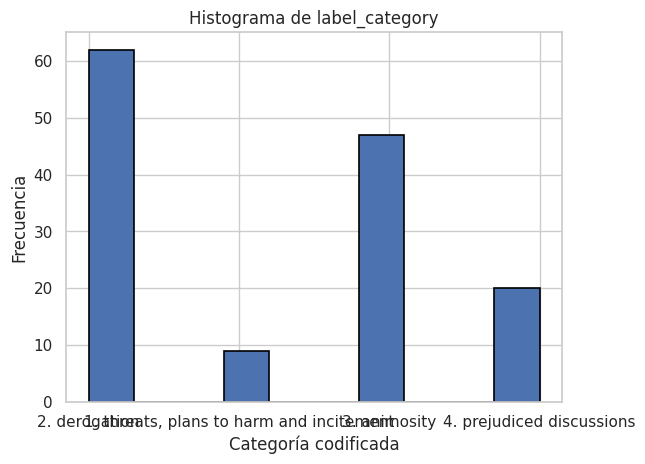

In [39]:
#desarrollar aquí con esos parámetros
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing


#Histograma del atributo clase
ax=plt.subplots(1,1,figsize=(10,8))
sns.countplot(x=conteo_tipos,data=datos)
plt.title("Datos Commit Count")
plt.show()




# Histograma de la columna codificada
df_count['label_category'].hist(edgecolor='black', linewidth=1.2)
plt.xlabel('Categoría codificada')
plt.ylabel('Frecuencia')
plt.title('Histograma de label_category')
plt.show()

# imprime esto:
# EVALUACIÓN:
# Accuracy: //resultado aquí

# Matriz de confusión: //imprime debajo

**PARAMETROS:** El parámetro que vas a usar y su respectivos resultados de la evaluación:


In [ ]:
#desarrollar aquí con esos parámetros

# imprime esto:
# EVALUACIÓN:
# Accuracy: //resultado aquí

# Matriz de confusión: //imprime debajo

**Requisito:** Una explicación o análisis del resultado final obtenido por los modelos con los parámetros ajustados debe incluir métricas de evaluación como accuracy, y matrices de
confusión. Este análisis también debe aparecer descrito y documentado en el notebook de trabajo.

//añadir las fuentes

## **Balanceando los datos (*si es necesario*):**

*Con el resultado de la matriz de confusion y el accuracy se sabrá si el desbalanceamiento afecta o no afecta a los resultados, si lo afecta entonces si se debe balancearlos.*

*También se sabrá si el modelo está sobreajustado (**Overfitting**) o **Underfitting**, un buen resultado es un accuracy arriba del 90%*

# 🔴 **Resultado final**

//Modelo seleccionado, hacer analisis de datos y dar resultado

**Requisito:** Conclusiones de los resultados obtenidos de acuerdo con el objetivo del conjunto de datos asignado, incluyendo trabajo futuro que se pueda realizar para mejorar los
resultados, o la evaluación del modelo. Estas deben estar de manera explícita en el notebook de trabajo.

//añadir las fuentes

# 🟤 **Referencias bibliográficas:**





1.   Elemento de lista
2.   Elemento de lista

